In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import scipy.signal as signal

In [2]:
plt.style.use('notebook')

In [3]:
tin = Table.read('../data/aguirre.txt', format='ascii')

In [120]:
tin

TIC,HIP,numax,Stnumax,Synumax,Delnu,StDelNu,SyDelNu,Vmag,e_Vmag,Teff,e_Teff,[Fe/H],e_[Fe/H],R,StR,SyR,M,StM,SyM,Age,StAge,SyAge,Ref
,,uHz,uHz,uHz,uHz,uHz,uHz,mag,mag,K,K,[Sun],[Sun],Rsun,Rsun,Rsun,Msun,Msun,Msun,Gyr,Gyr,Gyr,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19
13097379,114842,59.1,1.5,1.01,6.02,0.03,0.24,6.646,0.01,4634.0,80.0,0.04,0.08,8.49,0.28,0.17,1.22,0.08,0.06,6.1,1.06,0.97,2015AJ....150...88L
38574220,19805,29.4,0.9,0.72,4.06,0.2,0.26,5.577,0.009,-9999.99,--,-9999.99,--,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,--
38828538,21253,189.9,1.6,0.42,14.9,0.1,0.13,5.896,0.009,4828.0,80.0,0.11,0.08,4.66,0.1,0.06,1.21,0.05,0.03,6.2,0.5,1.02,2015MNRAS.448.2749A
39082723,4293,49.3,2.1,1.99,5.2,0.1,0.06,5.574,0.009,4706.0,80.0,-0.05,0.08,9.3,0.27,0.17,1.19,0.09,0.07,5.9,1.2,1.37,2015MNRAS.448.2749A
47424090,112612,28.3,1.8,1.9,3.4,0.1,0.29,6.93,0.01,-9999.99,--,-9999.99,--,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,--
70797228,655,31.8,1.5,0.75,4.37,0.2,0.37,5.787,0.009,4750.0,80.0,0.12,0.08,11.27,0.61,0.47,1.19,0.13,0.11,6.8,2.2,2.2,2011A&A...536A..71J
77116701,103071,48.3,7.6,29.85,5.64,0.2,3.37,8.568,0.018,-9999.99,--,-9999.99,--,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,--
111750740,113148,142.6,2.7,1.11,11.8,0.1,0.23,5.658,0.009,4688.0,80.0,0.16,0.08,5.11,0.16,0.09,1.06,0.07,0.05,10.8,1.78,1.71,2016AJ....152...19W


In [183]:
numax_err = np.sqrt(tin['Stnumax']**2 + tin['Synumax']**2)
dnu_err = np.sqrt(tin['StDelNu']**2 + tin['SyDelNu']**2)

## TESS giant with a single sector of data

In [90]:
i0 = 0
t = Table.read('../data/bulk/lc_tic_{:09d}.fits'.format(tin['TIC'][i0]))

In [93]:
sec = np.unique(t['sector_id'])
ind_clip = np.zeros(len(t), dtype='bool')

for s in sec:
    ind = t['sector_id']==s
    ind_clip[ind] = np.abs(t['fcorr'][ind]/np.nanmedian(t['fcorr'][ind])-1)<0.1
#     ind_clip = np.abs(t['fcorr']/np.nanmedian(t['fcorr'])-1)<0.002
tm = t['t'][ind_clip]
fm = t['fnorm'][ind_clip] - np.mean(t['fnorm'][ind_clip])

In [114]:
np.max(tm)-np.min(tm)

27.353873462166575

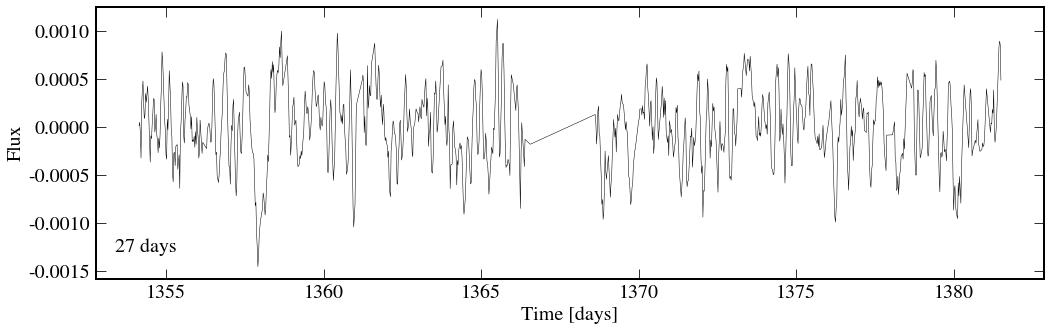

In [116]:
plt.figure(figsize=(15,5))
plt.plot(tm, fm, 'k-', lw=0.5)

plt.text(0.02,0.1,'{:.0f} days'.format(np.max(tm)-np.min(tm)), transform=plt.gca().transAxes)
# plt.axhline(0.0005, color='r')
# plt.axhline(-0.0005, color='r')
plt.xlabel('Time [days]')
plt.ylabel('Flux')

plt.tight_layout()
plt.savefig('../plots/lc_tic_{:09d}.png'.format(tin['TIC'][i0]))

In [117]:
# freq = np.logspace(-3,0,1000)
Nfreq = 100000
freq = np.linspace(1,200,Nfreq)
frlin = (freq / (2*np.pi) * u.day**-1).to(u.uHz)

In [118]:
pgram = signal.lombscargle(tm, fm, freq, normalize=True)

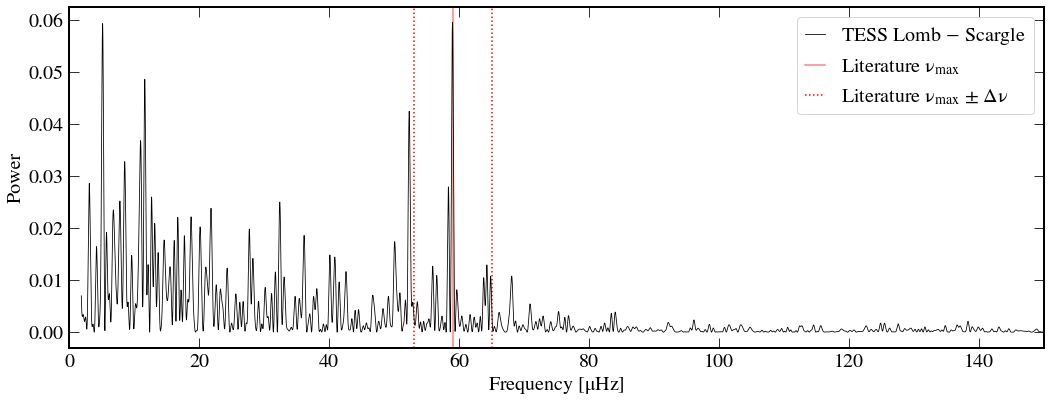

In [119]:
plt.figure(figsize=(15,6))
plt.plot(frlin, pgram, 'k-', lw=0.8, zorder=10, label='TESS Lomb $-$ Scargle')
plt.axvline(tin['numax'][i0], color='r', alpha=0.5, label='Literature $\\nu_{max}$')
plt.axvline(tin['numax'][i0]-tin['Delnu'][i0], color='r', ls=':', label='Literature $\\nu_{max}$ $\pm$ $\Delta\\nu$')
plt.axvline(tin['numax'][i0]+tin['Delnu'][i0], color='r', ls=':', label='')

plt.legend(handlelength=1)
plt.xlim(0,150)
plt.xlabel('Frequency [$\mu$Hz]')
plt.ylabel('Power')

plt.tight_layout()
plt.savefig('../plots/lsp_tic_{:09d}_{:06d}.png'.format(tin['TIC'][i0], Nfreq))

### Likelihood analysis

In [121]:
def ln_profile_like_K_freqs(ts, ys, yivars, nu, deltanu, K=3):
  assert len(ts) == len(ys)
  halfK = (K - 1) // 2
  thisK = 2 * halfK + 1
  A = np.zeros((len(ts), 2 * thisK + 1))
  for k in range(thisK):
    f = nu - halfK * deltanu + k * deltanu
    A[:, 2 * k]     = np.cos(2. * np.pi * f * ts)
    A[:, 2 * k + 1] = np.sin(2. * np.pi * f * ts)
  A[:, -1] = 1.
  resid = ys - np.dot(A, np.linalg.solve(np.dot(A.T * yivars, A), np.dot(A.T * yivars, ys)))
  return -0.5 * np.sum(yivars * resid ** 2)

In [124]:
ivar = (np.ones_like(fm)*1e-4)**-1

In [136]:
freqs = np.linspace(20,100,2000)*u.uHz
dfreq0 = 0.1*u.uHz

freqs_iday = freqs.to(u.day**-1).value
dfreq0_iday = dfreq0.to(u.day**-1).value

In [137]:
K0 = 3
fll = np.array([ln_profile_like_K_freqs(tm, fm, ivar, f, dfreq0_iday, K=K0) for f in freqs_iday])

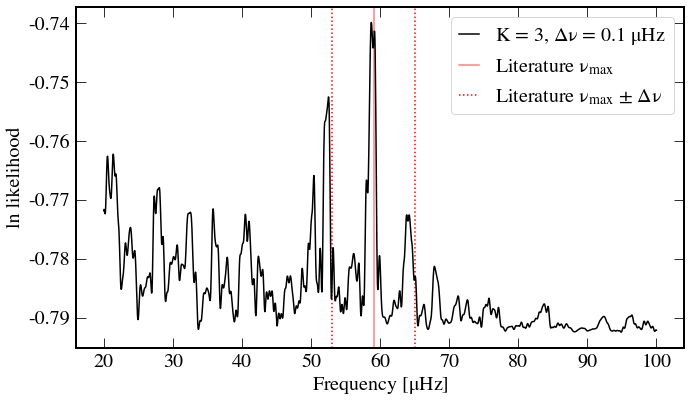

In [144]:
plt.figure(figsize=(10,6))
plt.plot(freqs, fll, 'k-', zorder=10, label='K = {:d}, $\Delta\\nu$ = {:.1f} $\mu$Hz'.format(K0, dfreq0.value))

plt.axvline(tin['numax'][i0], color='r', alpha=0.5, label='Literature $\\nu_{max}$')
plt.axvline(tin['numax'][i0]-tin['Delnu'][i0], color='r', ls=':', label='Literature $\\nu_{max}$ $\pm$ $\Delta\\nu$')
plt.axvline(tin['numax'][i0]+tin['Delnu'][i0], color='r', ls=':', label='')

plt.legend(handlelength=1)
plt.xlabel('Frequency [$\mu$Hz]')
plt.ylabel('ln likelihood')

plt.tight_layout()

### 2D likelihood surface

In [178]:
freqs = np.linspace(40,80,100)*u.uHz
dfreqs = np.linspace(4,8,100)*u.uHz

freqs_iday = freqs.to(u.day**-1).value
dfreqs_iday = dfreqs.to(u.day**-1).value

In [179]:
# do a two-d likelihood surface
lls = np.zeros((len(dfreqs), len(freqs)))
for i,f in enumerate(freqs_iday):
  for j,df in enumerate(dfreqs_iday):
    lls[j, i] = ln_profile_like_K_freqs(tm, fm, ivar, f, df, K=K0)

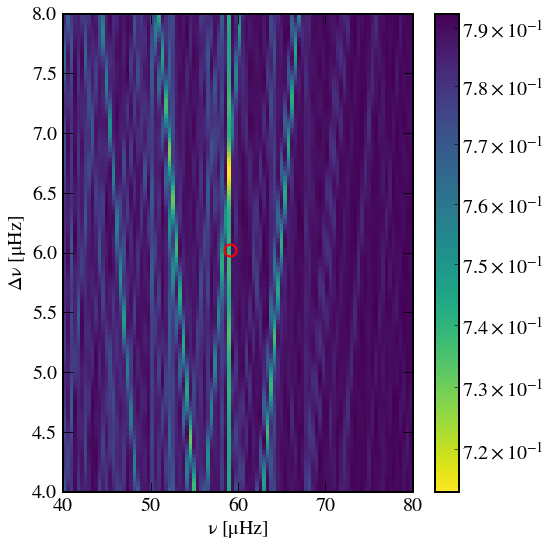

In [189]:
plt.plot(tin['numax'][i0], tin['Delnu'][i0], 'o', ms=12, mec='r', c='none', mew=2)

plt.imshow(np.abs(lls), origin='lower', extent=[freqs[0].value, freqs[-1].value, dfreqs[0].value, dfreqs[-1].value],
           aspect='auto', norm=mpl.colors.LogNorm(), cmap='viridis_r')

plt.xlim(freqs[0].value, freqs[-1].value)
plt.ylim(dfreqs[0].value, dfreqs[-1].value)
plt.xlabel('$\\nu$ [$\mu$Hz]')
plt.ylabel('$\Delta\\nu$ [$\mu$Hz]')
plt.colorbar()

plt.tight_layout()

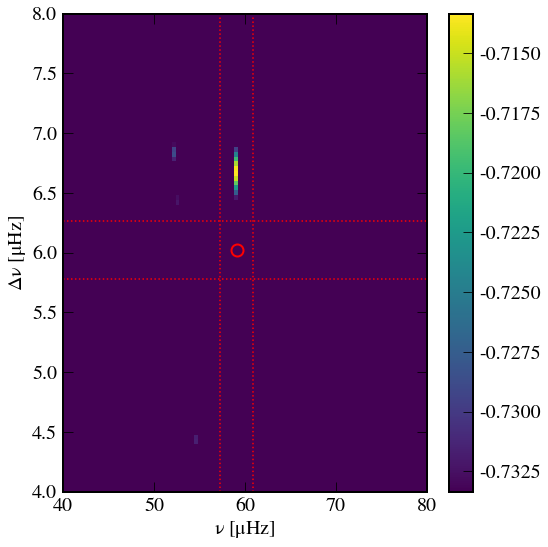

In [188]:
plt.plot(tin['numax'][i0], tin['Delnu'][i0], 'o', ms=12, mec='r', c='none', mew=2)
plt.axvline(tin['numax'][i0]-numax_err[i0], color='r', ls=':')
plt.axvline(tin['numax'][i0]+numax_err[i0], color='r', ls=':')
plt.axhline(tin['Delnu'][i0]-dnu_err[i0], color='r', ls=':')
plt.axhline(tin['Delnu'][i0]+dnu_err[i0], color='r', ls=':')

plt.imshow(lls, origin='lower', extent=[freqs[0].value, freqs[-1].value, dfreqs[0].value, dfreqs[-1].value],
           aspect='auto', cmap='viridis', vmin=np.max(lls)-0.02, vmax=np.max(lls))

plt.xlim(freqs[0].value, freqs[-1].value)
plt.ylim(dfreqs[0].value, dfreqs[-1].value)
plt.xlabel('$\\nu$ [$\mu$Hz]')
plt.ylabel('$\Delta\\nu$ [$\mu$Hz]')
plt.colorbar()

plt.tight_layout()

## Aguirre catalog

In [43]:
tlist = []

for i in range(len(tin)):
    t = Table.read('../data/bulk/lc_tic_{:09d}.fits'.format(tin['TIC'][i]))
    tlist += [t]

In [52]:
print(np.min(tin['numax']), np.max(tin['numax']))

27.6 189.9


In [57]:
freq = np.linspace(1,200,2000)
frlin = (freq / (2*np.pi) * u.day**-1).to(u.uHz)

In [58]:
print(np.min(frlin), np.max(frlin))

1.8420711006006407 uHz 368.4142201201281 uHz


In [66]:
tm = []
fm = []

for t in tlist:
    sec = np.unique(t['sector_id'])
    ind_clip = np.zeros(len(t), dtype='bool')
    for s in sec:
        ind = t['sector_id']==s
        ind_clip[ind] = np.abs(t['fcorr'][ind]/np.nanmedian(t['fcorr'][ind])-1)<1
#     ind_clip = np.abs(t['fcorr']/np.nanmedian(t['fcorr'])-1)<0.002
    tm += [t['t'][ind_clip]]
    fm += [t['fnorm'][ind_clip] - np.mean(t['fnorm'][ind_clip])]

In [67]:
for i in range(24):
    print(i, np.std(fm[i]))

0 0.00039136693901203467
1 0.0005610105628048978
2 0.001759145236469796
3 0.00010071831130518987
4 0.0006347431291776873
5 0.0002347571878613776
6 0.0001907553631862418
7 0.00015741756976958777
8 0.0002725605511917401
9 0.0001254386298708227
10 0.0006021414195221096
11 0.001001914672191336
12 0.00027808020006132633
13 0.0006537621378954884
14 0.0003879078229111412
15 0.00010488601149473809
16 0.0005834544979139236
17 0.00016378453295058532
18 0.00015385064929936482
19 0.00014100850965994256
20 0.00029004918001995447
21 0.00043441588348781124
22 0.0007513064774752455
23 0.08049774245465456


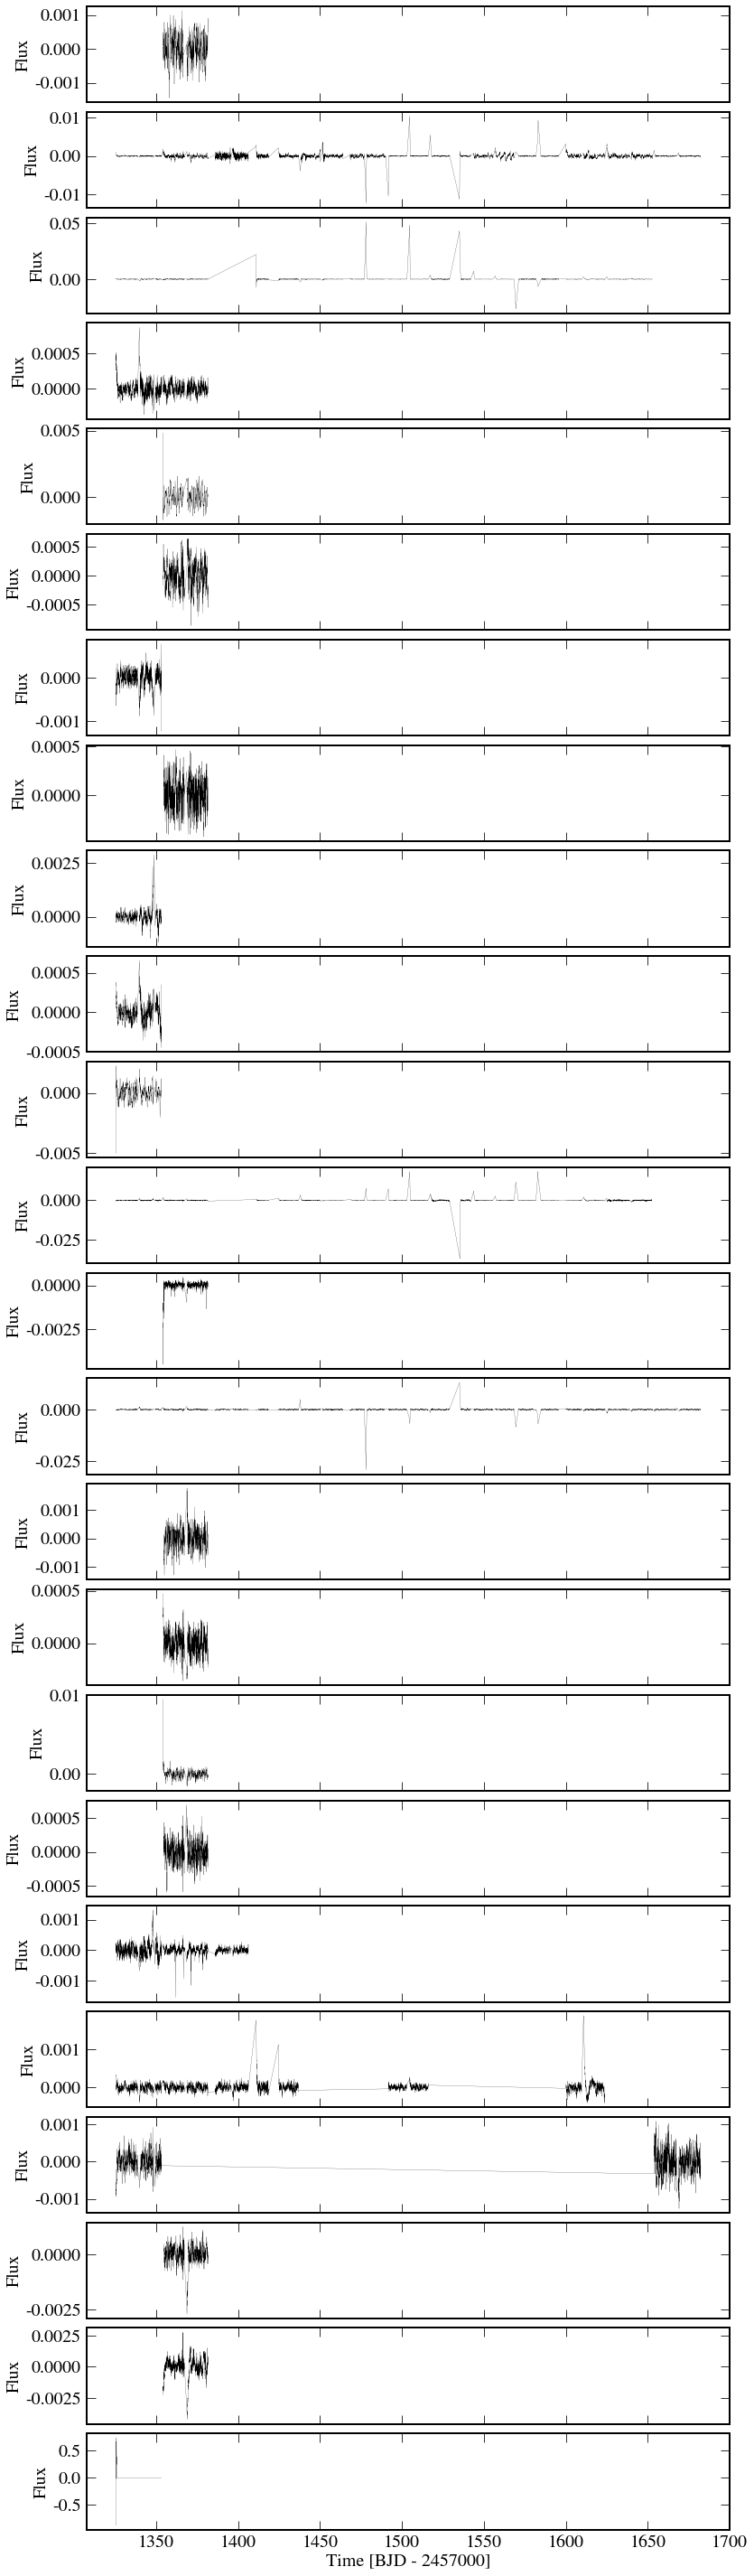

In [68]:
fig, ax = plt.subplots(24,1,figsize=(12,40), sharex=True)

for i in range(24):
    plt.sca(ax[i])
    plt.plot(tm[i], fm[i], 'k-', lw=0.2)
    plt.ylabel('Flux')
#     plt.ylim(-0.0019,0.0019)

plt.xlabel('Time [BJD - 2457000]')

plt.tight_layout(h_pad=0)

In [61]:
pgram = []

for i in range(24):
    p_ = signal.lombscargle(tm[i], fm[i], freq, normalize=True)
    pgram += [p_]

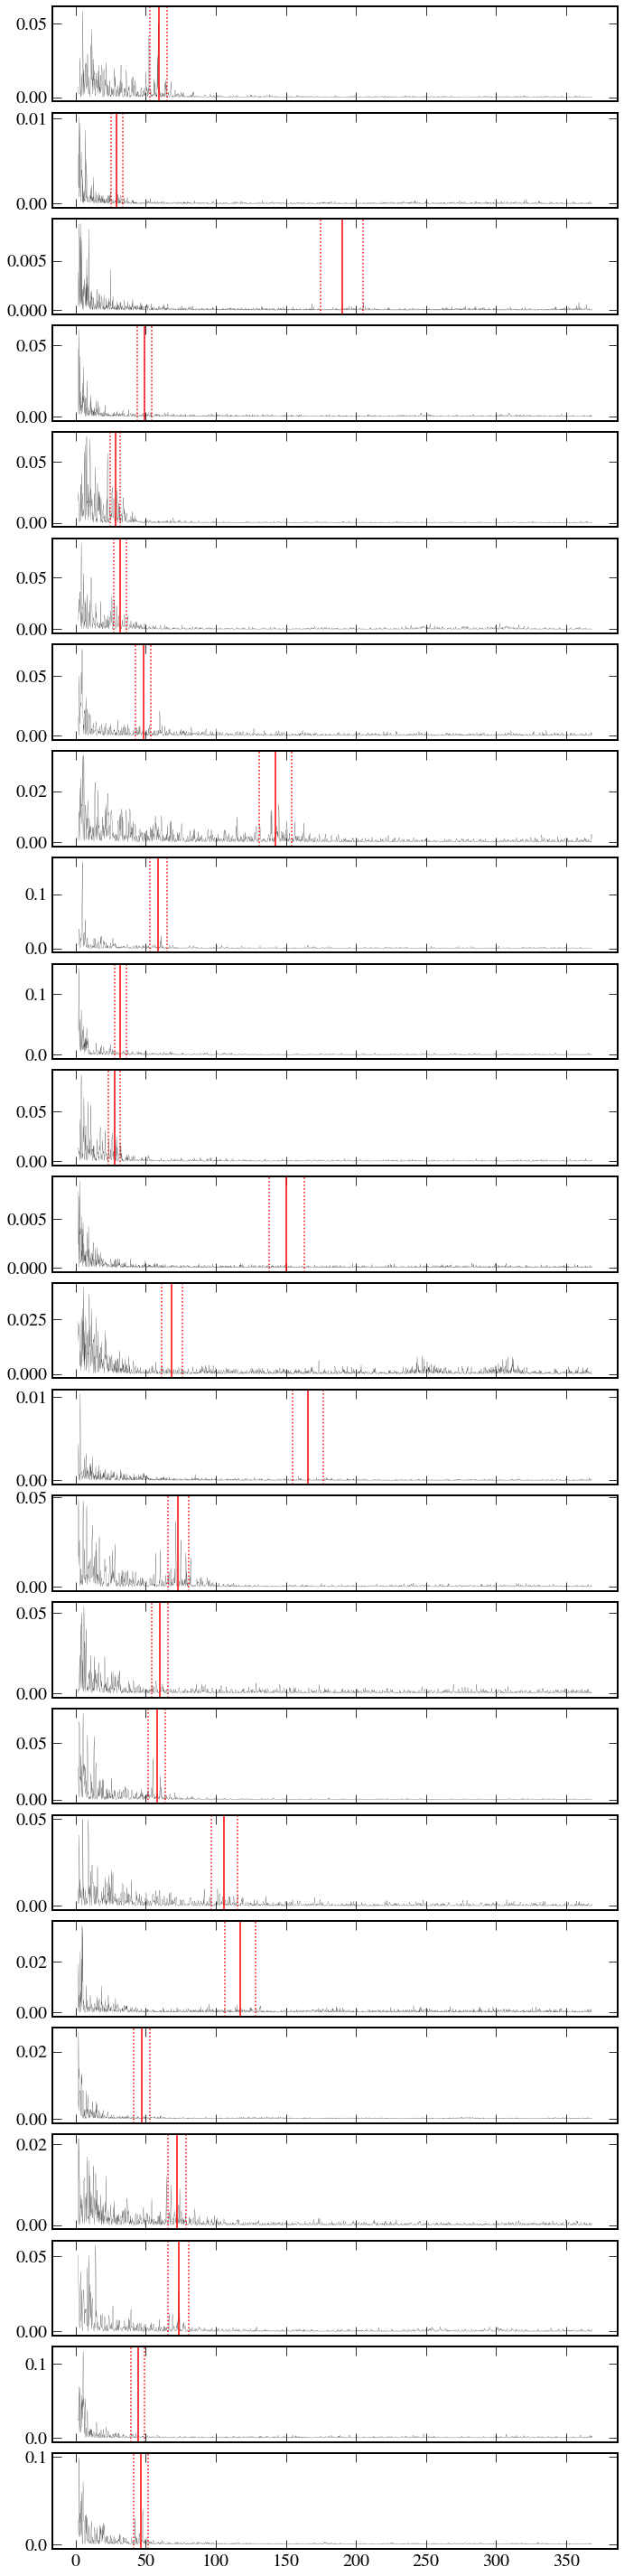

In [62]:
fig, ax = plt.subplots(24,1,figsize=(10,40), sharex=True)

for i in range(24):
    plt.sca(ax[i])
    
    plt.plot(frlin, pgram[i], 'k-', lw=0.2)
    
    plt.axvline(tin['numax'][i], color='r')
    plt.axvline(tin['numax'][i]-tin['Delnu'][i], color='r', ls=':')
    plt.axvline(tin['numax'][i]+tin['Delnu'][i], color='r', ls=':')
    
# plt.xlim(0,600)
plt.tight_layout(h_pad=0)

In [3]:
tlist = []

for i in range(10):
    t = Table.read('../data/bulk/lc_{:04d}.fits'.format(i))
    tlist += [t]

In [4]:
tm = []
fm = []

for t in tlist:
    sec = np.unique(t['sector_id'])
    ind_clip = np.zeros(len(t), dtype='bool')
    for s in sec:
        ind = t['sector_id']==s
        ind_clip[ind] = np.abs(t['fcorr'][ind]/np.nanmedian(t['fcorr'][ind])-1)<0.002
#     ind_clip = np.abs(t['fcorr']/np.nanmedian(t['fcorr'])-1)<0.002
    tm += [t['t'][ind_clip]]
    fm += [t['fnorm'][ind_clip] - np.mean(t['fnorm'][ind_clip])]
    
#     tm += [t['t']]
#     fm += [t['fnorm'] - np.mean(t['fnorm'])]

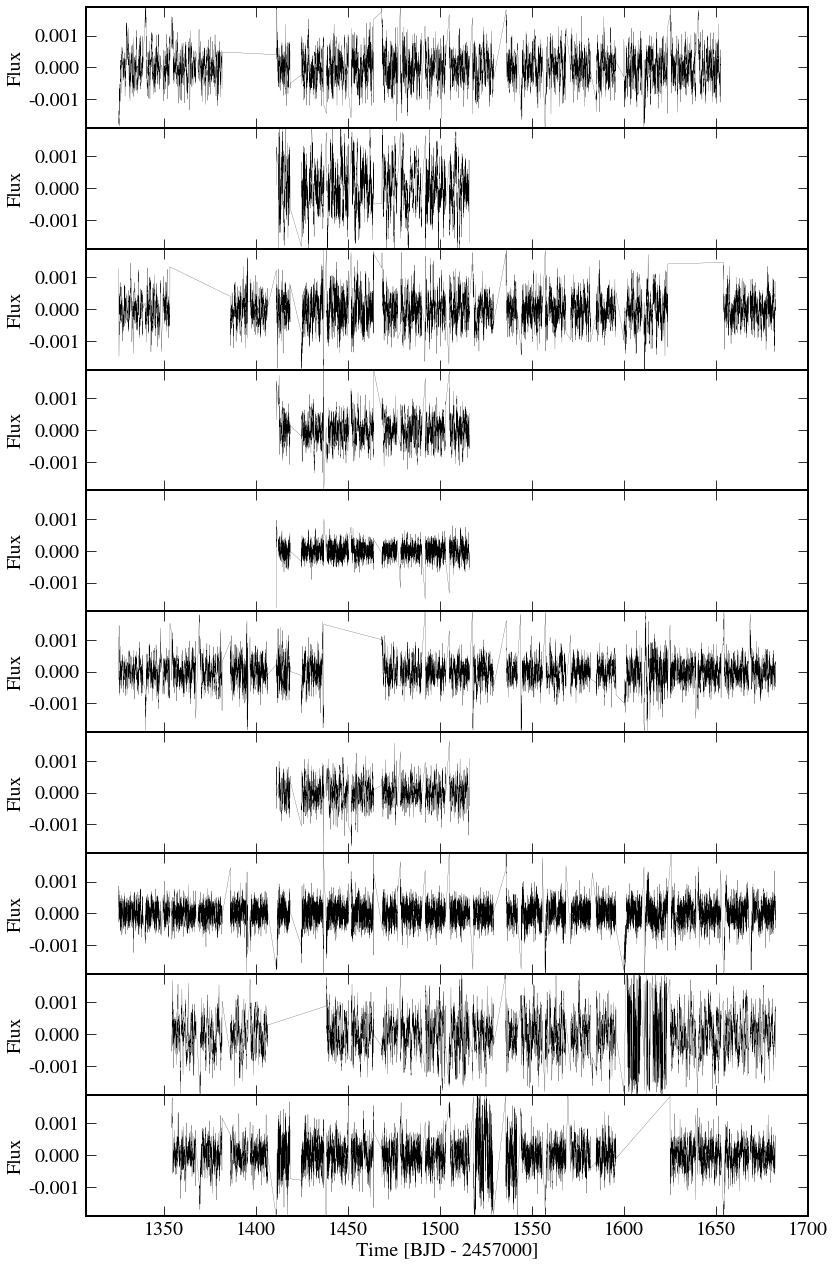

In [5]:
fig, ax = plt.subplots(10,1,figsize=(12,18), sharex=True, sharey=True)

for i in range(10):
    plt.sca(ax[i])
    plt.plot(tm[i], fm[i], 'k-', lw=0.2)
    plt.ylabel('Flux')
    plt.ylim(-0.0019,0.0019)

plt.xlabel('Time [BJD - 2457000]')

plt.tight_layout(h_pad=0)

In [11]:
freq = np.linspace(0.1,60,2000)
fr = (freq/u.day).to(u.microhertz)

In [12]:
pgram = []

for i in range(10):
    p_ = signal.lombscargle(tm[i], fm[i], freq, normalize=True)
    pgram += [p_]

In [28]:
# find numax
numax = np.empty(10)*u.uHz
nutop = 60*u.uHz

for i in range(10):
    ind_max = np.argmax(pgram[i][fr<nutop])
    numax[i] = fr[fr<nutop][ind_max]

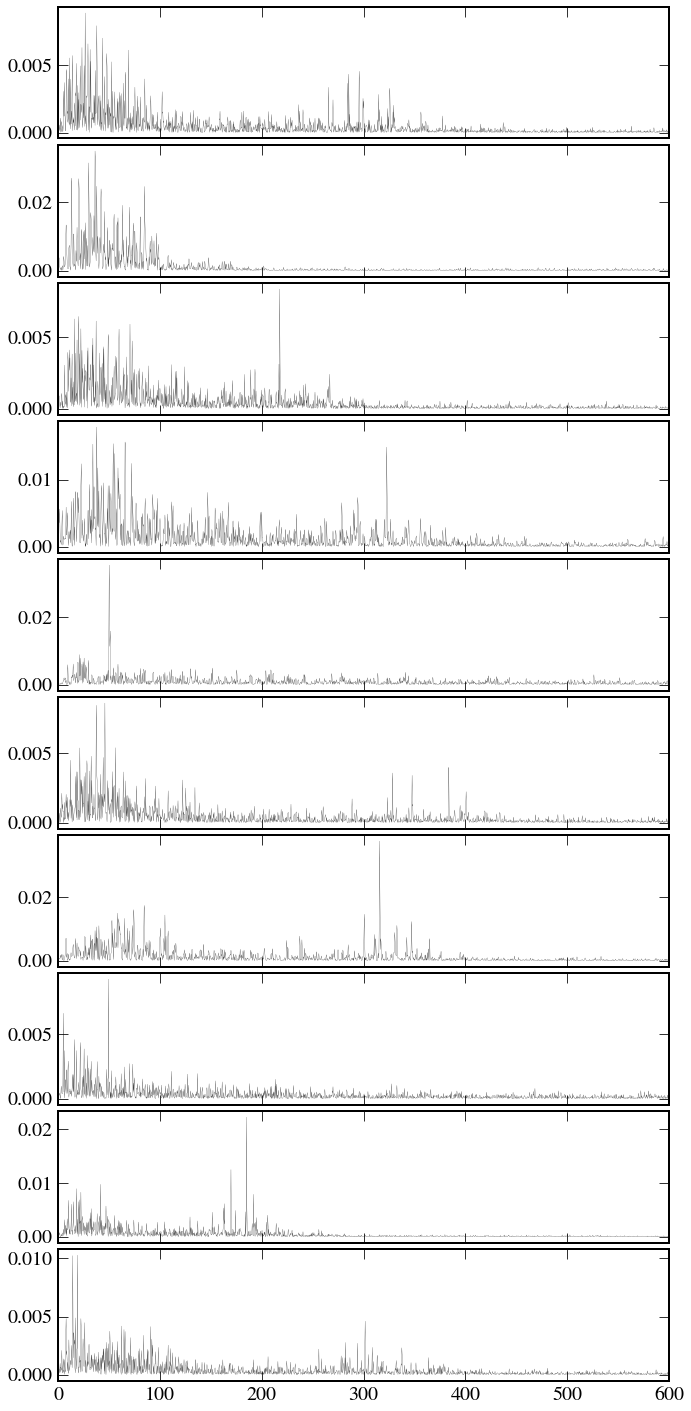

In [15]:
fig, ax = plt.subplots(10,1,figsize=(10,20), sharex=True)

for i in range(10):
    plt.sca(ax[i])
    plt.plot(fr, pgram[i], 'k-', lw=0.2)
    
plt.xlim(0,600)
plt.tight_layout(h_pad=0)

In [16]:
g = Table.read('../data/giants.fits')

In [17]:
distance = 1/g['parallax'] * u.kpc / u.mas
dm = 5*np.log10(distance.to(u.pc).value) - 5
G = g['phot_g_mean_mag'] - dm
G0 = G - np.nanmedian(g['a_g_val'])
# G0 = G - g['a_g_val']

/usr/lib64/python3.6/site-packages/numpy/lib/function_base.py:3523: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


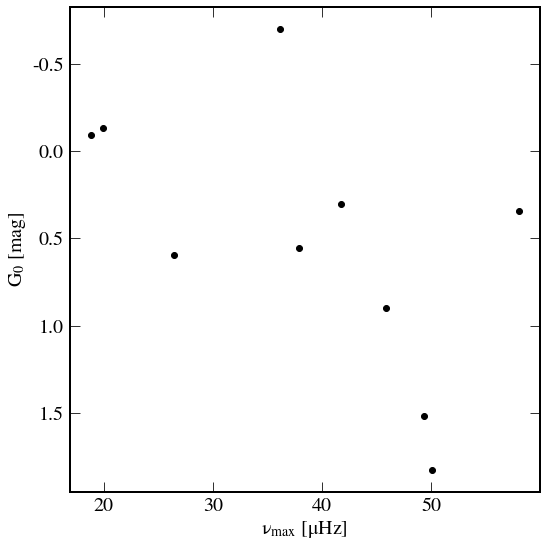

In [29]:
plt.plot(numax, G0[:10], 'ko')

plt.gca().invert_yaxis()
# plt.gca().set_xscale('log')
plt.xlabel('$\\nu_{max}$ [$\mu$Hz]')
plt.ylabel('G$_0$ [mag]')
plt.tight_layout()